### Import Library

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,Model
from tensorflow.keras.datasets import mnist

### Import Dataset

In [3]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

In [4]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

### Define bounding box

In [5]:
bbox_train = np.array([[14,14,14] for _ in range(len(x_train))])
bbox_test = np.array([[14,14,14,14] for _ in range(len(x_test))])

### Define custom model architechture

In [6]:
def custom_model():
    inputs = layers.Input(shape=(28,28,1))
    x = layers.Conv2D(32,(3,3),activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2),padding='same')(x)
    x = layers.Conv2D(64,(3,3),activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2),padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    
    # Output layers for classification and localization
    class_output = layers.Dense(10,activation='softmax',name='class_output')(x)
    loc_output = layers.Dense(4,name='loc_output')(x)
    
    model = Model(inputs=inputs,outputs=[class_output,loc_output])
    return model

model=custom_model()

In [7]:
def custom_loss(y_true, y_pred):
    # Classification loss
    class_loss = tf.keras.losses.sparse_categorical_crossentropy(tf.cast(tf.squeeze(y_true[0]), tf.int32), y_pred[0])

    # Localization loss (MSE)
    loc_loss = tf.keras.losses.mean_squared_error(y_true[1], y_pred[1])

    # You might need to adjust the loss weights based on your problem
    total_loss = class_loss + loc_loss

    return total_loss


### Compile and Train Model

In [8]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train,[y_train,bbox_train],batch_size=32,epochs=10,validation_data=(x_test,[y_test,bbox_test]))


Epoch 1/10



ValueError: in user code:

    File "C:\Users\jayag\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\jayag\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\jayag\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\jayag\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\jayag\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "C:\Users\jayag\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\jayag\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\jayag\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\jayag\anaconda3\Lib\site-packages\keras\src\losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\jayag\anaconda3\Lib\site-packages\keras\src\backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((32, 10) vs (32, 1)).


In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def load_mnist():
    # Load dataset
    (train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
    
    # Function to normalize images and add bounding boxes
    def prepare_image(image, label):
        image = tf.cast(image, tf.float32) / 255.0  # Normalize image
        bbox = tf.constant([0.1, 0.1, 0.9, 0.9], dtype=tf.float32)  # Dummy bbox (x_min, y_min, x_max, y_max)
        return image, {'label': label, 'bbox': bbox}
    
    # Prepare data
    train_ds = train_ds.map(prepare_image).batch(32)
    test_ds = test_ds.map(prepare_image).batch(32)
    
    return train_ds, test_ds, ds_info

train_ds, test_ds, ds_info = load_mnist()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\jayag\tensorflow_datasets\mnist\3.0.1.incompleteGRN5TK\mnist-train.tfrecord*...:   0%|     …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\jayag\tensorflow_datasets\mnist\3.0.1.incompleteGRN5TK\mnist-test.tfrecord*...:   0%|      …

Dataset mnist downloaded and prepared to C:\Users\jayag\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


In [12]:
def build_model(num_classes):
    inputs = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    # Classification head
    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='label')(x)
    # Bounding box regression head
    bbox = tf.keras.layers.Dense(4, activation='sigmoid', name='bbox')(x)  # Sigmoid to output values between 0 and 1

    model = tf.keras.Model(inputs=inputs, outputs=[classification, bbox])
    return model

model = build_model(10)  # 10 classes for the digits 0-9


In [13]:
model.compile(optimizer='adam',
              loss={'label': 'sparse_categorical_crossentropy', 'bbox': 'mse'},
              metrics={'label': 'accuracy', 'bbox': 'mse'})

history = model.fit(train_ds, epochs=10, validation_data=test_ds)


Epoch 1/10



1875/1875 [==============================] - 12s 5ms/step - loss: 0.1306 - label_loss: 0.1289 - bbox_loss: 0.0017 - label_accuracy: 0.9594 - bbox_mse: 0.0017 - val_loss: 0.0518 - val_label_loss: 0.0512 - val_bbox_loss: 5.4694e-04 - val_label_accuracy: 0.9833 - val_bbox_mse: 5.4694e-04
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0428 - label_loss: 0.0424 - bbox_loss: 4.0284e-04 - label_accuracy: 0.9872 - bbox_mse: 4.0284e-04 - val_loss: 0.0362 - val_label_loss: 0.0359 - val_bbox_loss: 3.0767e-04 - val_label_accuracy: 0.9879 - val_bbox_mse: 3.0767e-04
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0284 - label_loss: 0.0281 - bbox_loss: 2.5887e-04 - label_accuracy: 0.9913 - bbox_mse: 2.5887e-04 - val_loss: 0.0382 - val_label_loss: 0.0380 - val_bbox_loss: 2.3431e-04 - val_label_accuracy: 0.9879 - val_bbox_mse: 2.3431e-04
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0201 - label_loss: 0.0199

In [14]:
loss, label_loss, bbox_loss, label_accuracy, bbox_mse = model.evaluate(test_ds)
print(f"Test accuracy: {label_accuracy}, BBox MSE: {bbox_mse}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0392 - label_loss: 0.0392 - bbox_loss: 2.3990e-07 - label_accuracy: 0.9930 - bbox_mse: 2.3990e-07
Test accuracy: 0.9929999709129333, BBox MSE: 2.398981848727999e-07


1/1 [==============================] - 0s 104ms/step


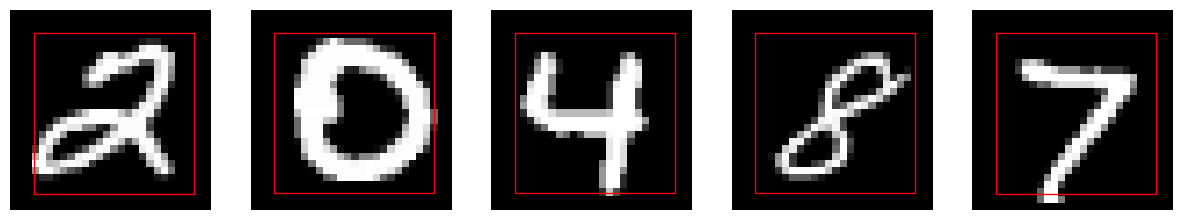

In [15]:
def plot_predictions(dataset):
    for images, targets in dataset.take(1):
        preds = model.predict(images)
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        for i, ax in enumerate(axes):
            ax.imshow(images[i, :, :, 0], cmap='gray')
            pred_bbox = preds[1][i] * 28  # Rescale bounding box to image size
            rect = plt.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2]-pred_bbox[0], pred_bbox[3]-pred_bbox[1], fill=False, color='red')
            ax.add_patch(rect)
            ax.axis('off')
        plt.show()

plot_predictions(test_ds)

### Model-2

In [23]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [ ]:
def preprocess(data):
    image = data['image']
    # Normalize and resize the image
    image = tf.image.resize(image, (300, 300))
    image = image / 255.0
    return image, data['objects']['bbox']

# Load the dataset
ds, ds_info = tfds.load('oxford_iiit_pet', split='test', with_info=True)
ds = ds.map(preprocess).batch(1)


In [ ]:
detector = hub.load('https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2')


In [ ]:
def run_detector(detector, dataset):
    for image, image_id, gt_boxes in dataset.take(5):  # Just take 5 examples
        converted_img  = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]
        result = detector(converted_img)
        result = {key:value.numpy() for key,value in result.items()}
        print("Found %d objects." % len(result["detection_scores"]))
        print("Inference time: ", result["inference_time"])
        
        image_np = image.numpy().squeeze()
        visualize(image_np, result['detection_boxes'], result['detection_scores'], result['detection_class_entities'])

def visualize(image, boxes, scores, classes):
    plt.figure(figsize=(10, 10))
    plt.imshow(image.astype(np.uint8))
    ax = plt.gca()

    for box, score, cls in zip(boxes, scores, classes):
        if score > 0.5:  # Only display detections above a certain threshold
            y1, x1, y2, x2 = box
            rect = patches.Rectangle((x1 * image.shape[1], y1 * image.shape[0]), (x2 - x1) * image.shape[1], (y2 - y1) * image.shape[0], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1 * image.shape[1], y1 * image.shape[0], f'{cls.decode("utf8")}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()



In [ ]:
run_detector(detector, ds)
